# Running A Backtest
In this example we will demonstrate how to run a backtest for a simple algo example

#### Loading the data bundle

In [14]:
import os

import warnings
warnings.filterwarnings('ignore')

os.environ['ZIPLINE_ROOT'] = '/home/hca-dev/.zipline'

os.listdir(os.environ['ZIPLINE_ROOT'])
#!os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), '.zipline')

os.listdir(os.environ['ZIPLINE_ROOT'])
import zipline
from zipline.data import bundles

bundle_name = 'alpaca_api'
bundle_data = bundles.load(bundle_name)
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.utils.calendars import get_calendar
from zipline.pipeline.data import USEquityPricing
from zipline.data.data_portal import DataPortal

import pandas as pd

# Set the dataloader
pricing_loader = USEquityPricingLoader.without_fx(bundle_data.equity_daily_bar_reader, bundle_data.adjustment_reader)


# Define the function for the get_loader parameter
def choose_loader(column):
    if column not in USEquityPricing.columns:
        raise Exception('Column not in USEquityPricing')
    return pricing_loader

# Set the trading calendar
trading_calendar = get_calendar('NYSE')

start_date = pd.Timestamp('2021-01-04', tz='utc')
end_date = pd.Timestamp('2021-01-29', tz='utc')
#start_date = pd.Timestamp('2019-07-05', tz='utc')
#end_date = pd.Timestamp('2020-11-13', tz='utc')

# Create a data portal
data_portal = DataPortal(bundle_data.asset_finder,
                         trading_calendar = trading_calendar,
                         first_trading_day = start_date,
                         equity_daily_reader = bundle_data.equity_daily_bar_reader,
                         adjustment_reader = bundle_data.adjustment_reader)

In [15]:
bundle_data.asset_finder.lookup_symbol("AMD", end_date)

Equity(10210 [AMD])

In [16]:
import dateutil.parser
from os.path import join, exists
import pandas as pd
import pandas_datareader.data as yahoo_reader
import yaml

import numpy as np


def get_benchmark(symbol=None, start = None, end = None, other_file_path=None):
    bm = yahoo_reader.DataReader(symbol,
                                 'yahoo',
                                 pd.Timestamp(start),
                                 pd.Timestamp(end))['Close']
    bm.index = bm.index.tz_localize('UTC')
    return bm.pct_change(periods=1).fillna(0)

In [17]:

from zipline.api import order_target, record, symbol
import matplotlib.pyplot as plt

def initialize(context):
    context.equity = bundle_data.asset_finder.lookup_symbol("AMD", end_date)

def handle_data(context, data):
    order_target(context.equity, 100)

def before_trading_start(context, data):
    pass

def analyze(context, perf):
    ax1 = plt.subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax2 = plt.subplot(212, sharex=ax1)
    perf.sym.plot(ax=ax2, color='r')
    plt.gcf().set_size_inches(18, 8)
    plt.legend(['Algo', 'Benchmark'])
    plt.ylabel("Returns", color='black', size=25)


Text(0, 0.5, 'Returns')

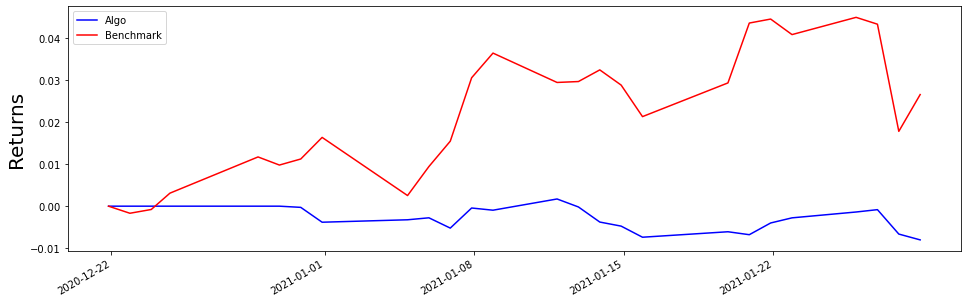

In [18]:
import pandas as pd
from datetime import datetime
import pytz

from zipline import run_algorithm

start = pd.Timestamp('2020-12-20', tz='utc')
end = pd.Timestamp('2021-01-28', tz='utc')
#orig
#start = pd.Timestamp(datetime(2020, 11, 1, tzinfo=pytz.UTC))
#end = pd.Timestamp(datetime(2020, 11, 1, tzinfo=pytz.UTC))

r = run_algorithm(start=start,
                  end=end,
                  initialize=initialize,
                  capital_base=100000,
                  handle_data=handle_data,
                  benchmark_returns=get_benchmark(symbol="SPY",
                                                  start=start.date().isoformat(),
                                                  end=end.date().isoformat()),
                  bundle='alpaca_api',
                  broker=None,
                  state_filename="./demo.state",
                  trading_calendar=trading_calendar,
                  before_trading_start=before_trading_start,
#                   analyze=analyze,
                  data_frequency='daily'
                  )
fig, axes = plt.subplots(1, 1, figsize=(16, 5), sharex=True)
r.algorithm_period_return.plot(color='blue')
r.benchmark_period_return.plot(color='red')

plt.legend(['Algo', 'Benchmark'])
plt.ylabel("Returns", color='black', size=20)


# Using Pyfolio to analyze your results

In [19]:
import pyfolio as pf
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(r)
benchmark_returns = r.benchmark_period_return

In [20]:
import empyrical
print("returns sharp ratio: {}".format(empyrical.sharpe_ratio(returns)))  # how much is it sensative to divergance. the higher the better
print("bencmark sharp ratio: {}".format(empyrical.sharpe_ratio(benchmark_returns)))
print("beta ratio: {}".format(empyrical.beta(returns, benchmark_returns))) # how much correlation between algo to benchmark. we want it to be clsoe to zero
print("alpha ratio: {}".format(empyrical.alpha(returns, benchmark_returns))) 



returns sharp ratio: -2.215288292873961
bencmark sharp ratio: 23.00870462844475
beta ratio: 0.027773671884305903
alpha ratio: -0.20769218611329376


## Position Tear Sheet

Top 10 long positions of all time,max
AMD,55.38%


Top 10 short positions of all time,max


Top 10 positions of all time,max
AMD,55.38%


All positions ever held,max
AMD,55.38%


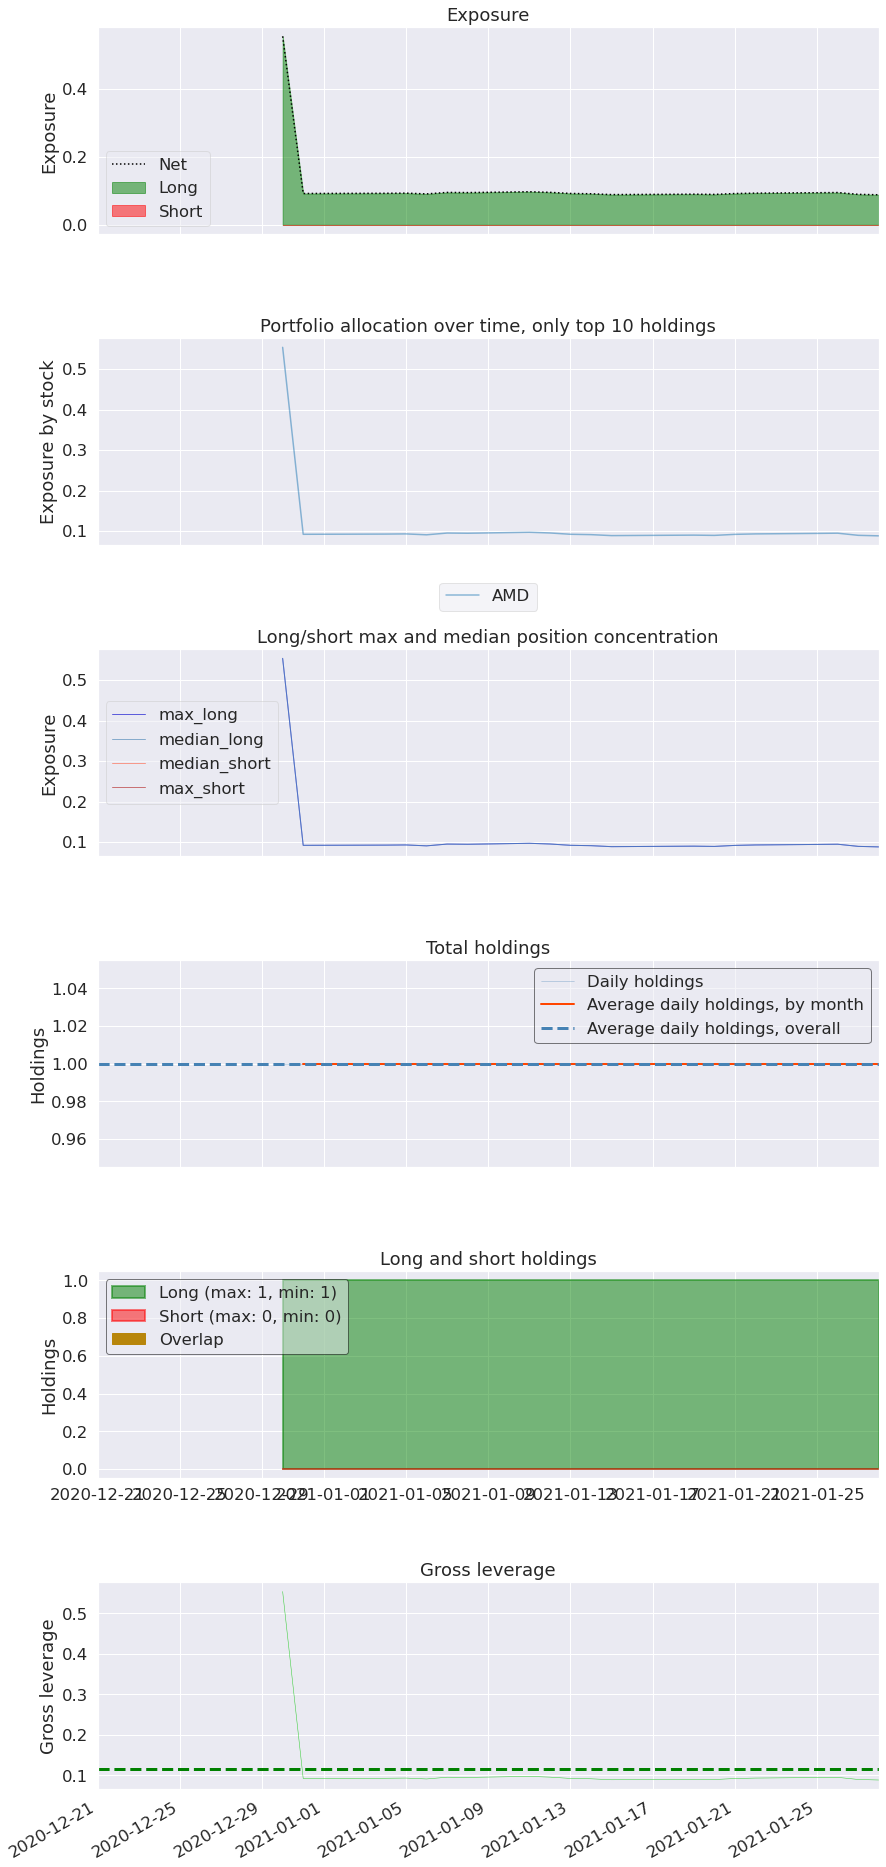

In [21]:
pf.create_position_tear_sheet(returns, positions=positions, transactions=transactions)

## Returns Tear Sheet

Entire data start date: 2020-12-22
Entire data end date: 2021-01-28
Backtest months: 1


,Backtest
Annual return,-7.8%
Cumulative returns,-0.8%
Annual volatility,3.6%
Sharpe ratio,-2.26
Calmar ratio,-8.02
Stability,0.35
Max drawdown,-1.0%
Omega ratio,0.66
Sortino ratio,-2.84
Skew,-0.21


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.97,2021-01-11,2021-01-28,NaT,NaN
1,0.52,2020-12-29,2021-01-06,2021-01-11,10
2,0.00,2020-12-22,2020-12-22,2020-12-22,1
3,0.00,2020-12-22,2020-12-22,2020-12-22,1
4,0.00,2020-12-22,2020-12-22,2020-12-22,1


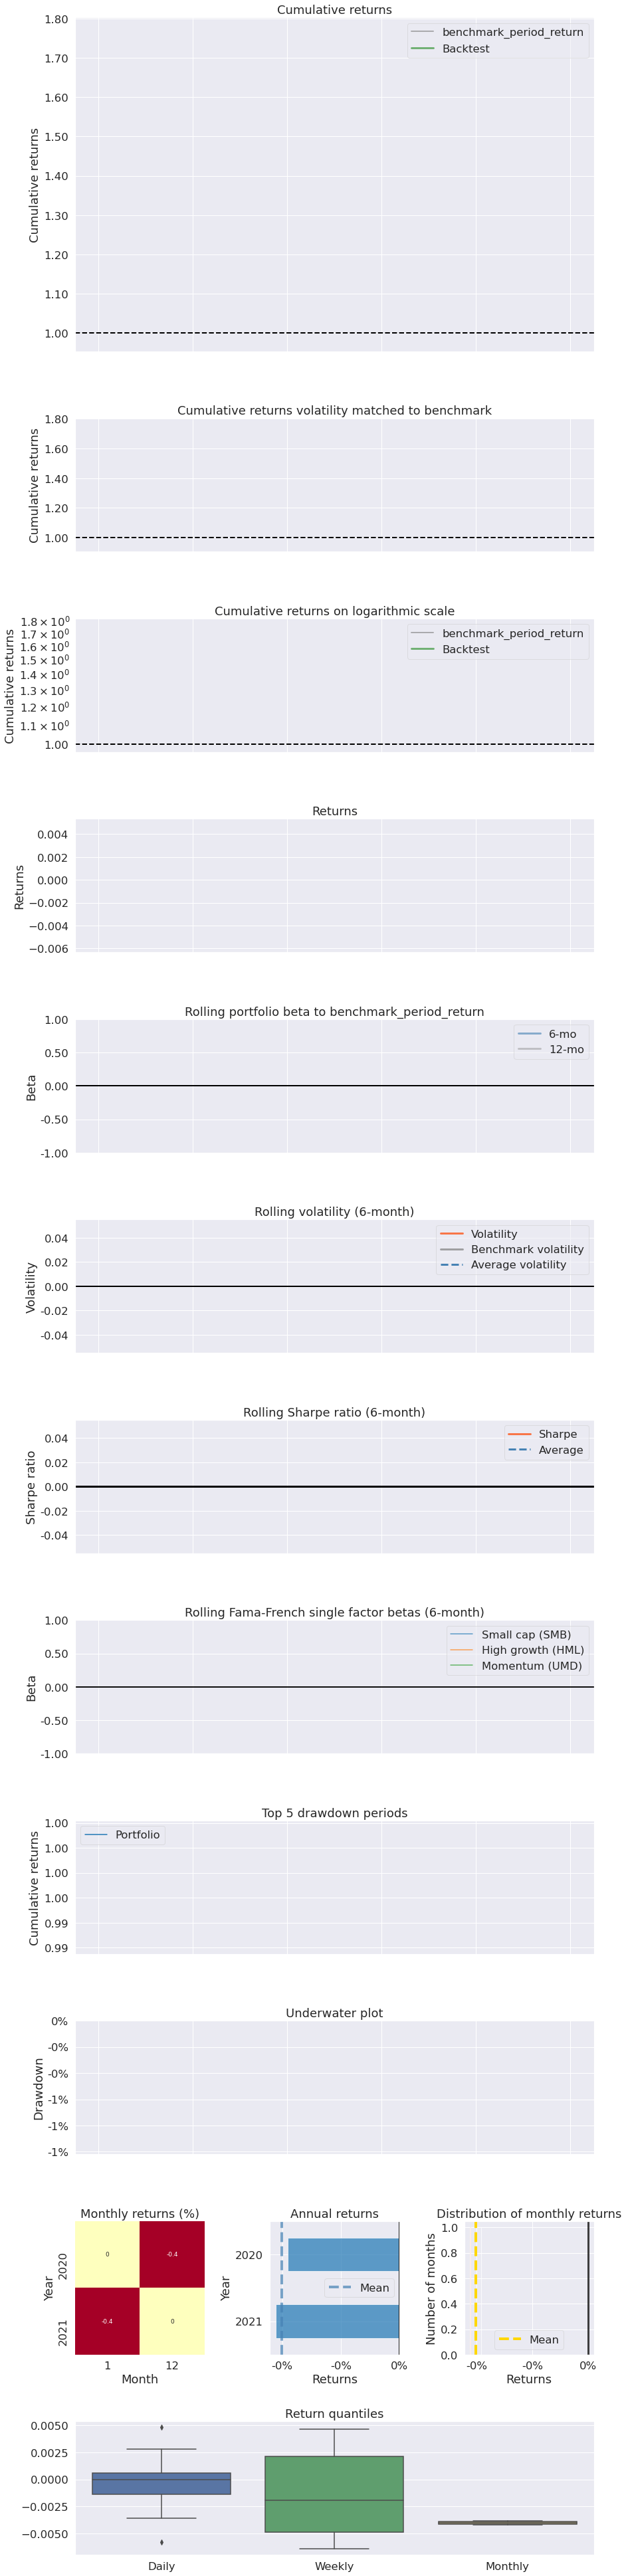

In [22]:
pf.create_returns_tear_sheet(returns, 
                             positions=positions, 
                             transactions=transactions,
                             benchmark_rets=benchmark_returns)

## Full Tear Sheet

Entire data start date: 2020-12-22
Entire data end date: 2021-01-06
In-sample months: 0
Out-of-sample months: 0


,All,In-sample,Out-of-sample
Annual return,-12.3%,nan%,-12.3%
Cumulative returns,-0.5%,nan%,-0.5%
Annual volatility,2.1%,nan%,2.1%
Sharpe ratio,-6.13,NaN,-6.13
Calmar ratio,-23.67,NaN,-23.67
Stability,0.74,NaN,0.74
Max drawdown,-0.5%,nan%,-0.5%
Omega ratio,0.17,NaN,0.17
Sortino ratio,-6.07,NaN,-6.07
Skew,-1.50,NaN,-1.50


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.52,2020-12-29,2021-01-06,NaT,NaN
1,0.00,2020-12-22,2020-12-22,2020-12-22,1
2,0.00,2020-12-22,2020-12-22,2020-12-22,1
3,0.00,2020-12-22,2020-12-22,2020-12-22,1
4,0.00,2020-12-22,2020-12-22,2020-12-22,1


TypeError: Empty 'DataFrame': no numeric data to plot

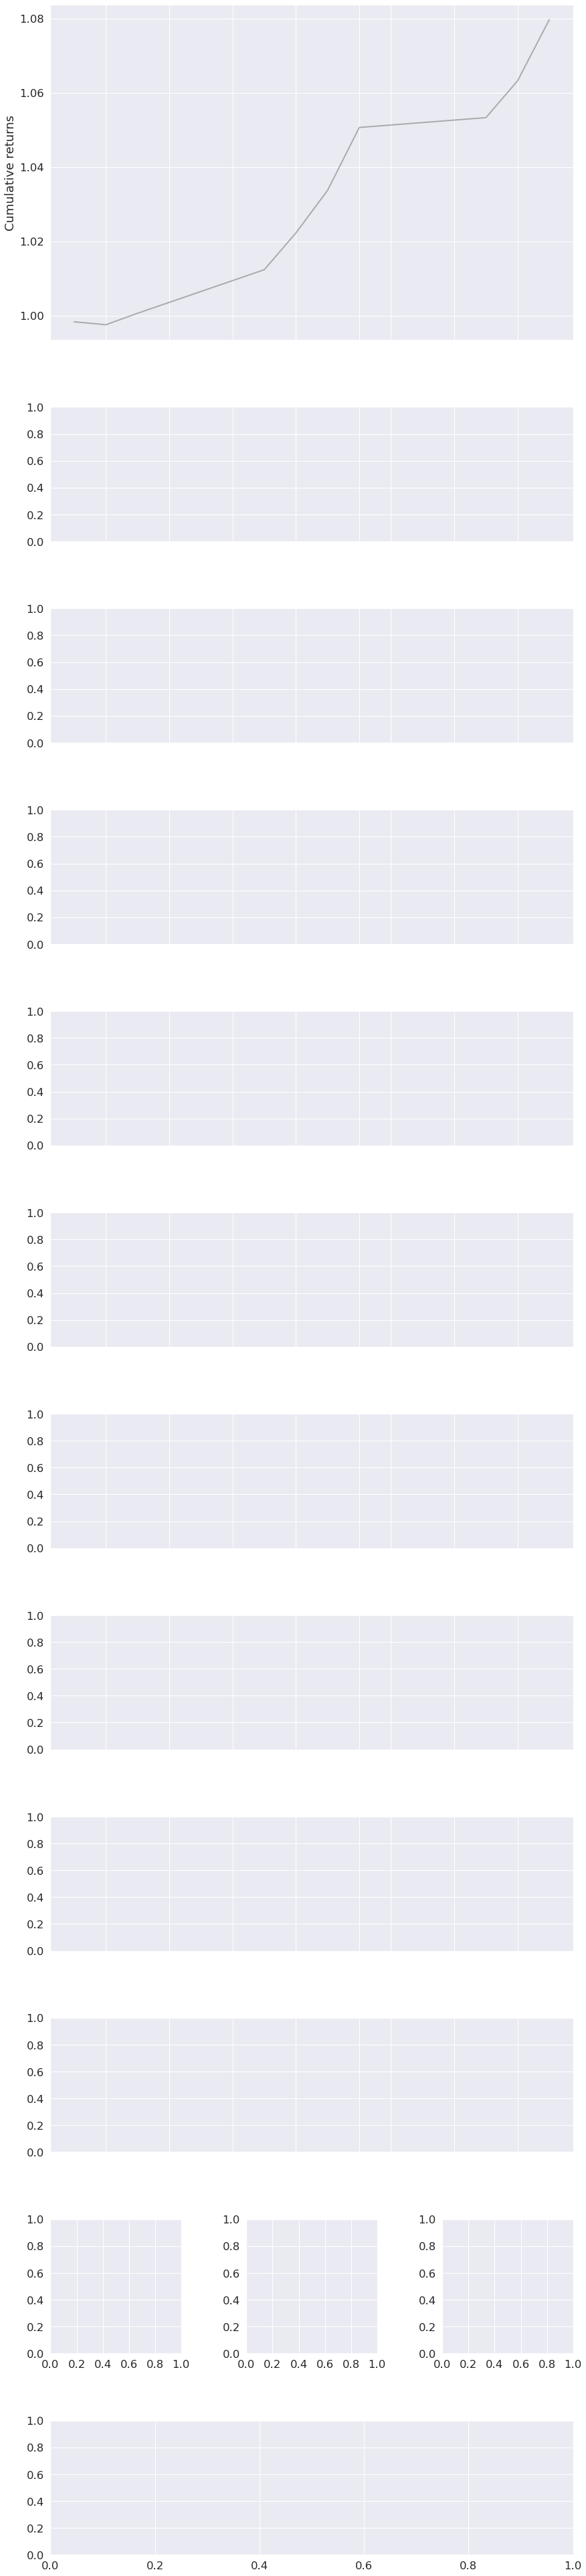

In [12]:

pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,                           
                          live_start_date='2020-11-20',
                          round_trips=True, 
                          benchmark_rets=benchmark_returns)